# Homework set 5

Before you turn this problem in, make sure everything runs as expected (in the menubar, select Kernel → Restart Kernel and Run All Cells...).

Please **submit this Jupyter notebook through Canvas** no later than **Mon Dec. 4, 9:00**. **Submit the notebook file with your answers (as .ipynb file) and a pdf printout. The pdf version can be used by the teachers to provide feedback. A pdf version can be made using the save and export option in the Jupyter Lab file menu.**

Homework is in **groups of two**, and you are expected to hand in original work. Work that is copied from another group will not be accepted.

# Exercise 0
Write down the names + student ID of the people in your group.

Koen Weverink (14711982) & Jasper Timmer (12854328)

# Exercise 1 (6 points)

A bacterial population $P$ grows according to the geometric progression

$$P_t = rP_{t-1}$$

Where r is the growth rate. The following population counts $P_1 ,\ldots, P_8$ (in billions) are observed:

In [11]:
import numpy as np

data = np.array( [0.19, 0.36, 0.69, 1.3, 2.5, 4.7, 8.5, 14] )

# (a)
Read chapter 6.6 on Nonlinear Least squares. Use the Gauss-Newton Method to fit the model function $f(t, x_1, x_2) = x_1\!\cdot x_2^t$ to the data. Find estimates for the initial population $P_0=x_1$ and the growth rate $r=x_2$. Implement the Gauss-Newton method yourself. You may use linear algebra functions from `scipy` and `numpy`. Plot the datapoints and the curve fitted to the data in a semilogarithmic plot.

It is best if you define your function for Gauss-Newton separately from the definitions associated with the bacterial model.

In [12]:
def residual(params, x, y, fitting_function, sigmas=1):
    """
    Compute the residuals between observed and model-predicted values.

    Parameters:
    - params (array-like): Parameters of the model.
    - x (array-like): Independent variable values.
    - y (array-like): Observed dependent variable values.
    - fitting_function (callable): Function defining the model to be fitted.
    - sigmas (float or array-like, optional): Weights for the residuals. Default is 1.

    Returns:
    - residuals (ndarray): Difference between observed and model-predicted values, normalized by sigmas.
    """

    return y / sigmas - fitting_function(params, x) / sigmas


def jacobian(params, x, y, fitting_function, residual, sigmas):
    """
    Calculate the Jacobian matrix using the central finite difference method.

    Parameters:
    - params (array-like): Current values of the parameters.
    - x (array-like): Independent variable values.
    - y (array-like): Observed dependent variable values.
    - fitting_function (callable): Function defining the model to be fitted. It should take
                                  parameters and independent variable as inputs and return
                                  the corresponding model values.
    - residual (callable): Function computing the residuals between the model predictions and
                          observed data given the parameters.
    - sigmas (float or array-like): Weights for the residuals.

    Returns:
    - jacobian_matrix (ndarray): Jacobian matrix evaluated at the given parameters.
    """ 

    h = 1e-10

    delta = np.array([h, 0])
    grad_x_1 = (residual(params + delta, x, y, fitting_function, sigmas) - residual(params - delta, x, y, fitting_function, sigmas)) / (2 * h)

    delta = np.array([0, h])
    grad_x_2 = (residual(params + delta, x, y, fitting_function, sigmas) - residual(params - delta, x, y, fitting_function, sigmas)) / (2 * h)

    return np.column_stack([grad_x_1, grad_x_2])


def gauss_newton(params_init, x, y, fitting_function, max_iterations=100 , tol=1e-6, sigmas = 1):
    """
    Perform Gauss-Newton optimization to fit a model to data.

    Parameters:
    - params_init (list or array-like): Initial guess for the parameters of the model.
    - x (array-like): Independent variable values.
    - y (array-like): Observed dependent variable values.
    - fitting_function (callable): Function defining the model to be fitted. It should take
                                  parameters and independent variable as inputs and return
                                  the corresponding model values.
    - max_iterations (int, optional): Maximum number of iterations for the optimization. Default is 100.
    - tol (float, optional): Tolerance for convergence. The optimization stops when the norm of the
                            step size or the residuals is below this threshold. Default is 1e-6.
    - sigmas (float or array-like, optional): Weights for the residuals. Default is 1.

    Returns:
    - params (ndarray): Optimized parameters for the model.
    """

    params = params_init[:]

    # Perform iterations
    for _ in range(max_iterations):

        # Calculate residual and Jacobian
        res = residual(params, x, y, fitting_function, sigmas)
        J = jacobian(params, x, y, fitting_function, residual, sigmas)
        
        # Determine parameters for next iteration
        step = np.linalg.lstsq(J, res, rcond=None)[0]
        params -= step

        # Check stopping conditions
        if np.linalg.norm(step) < tol or np.linalg.norm(res) < tol:
            break

    return params

In [13]:
def growth(params, x):
    p_0, r = params
    return p_0 * (r ** x)

Fitted parameters:
p_0: 0.28277066838680154
r: 1.7494028100026096


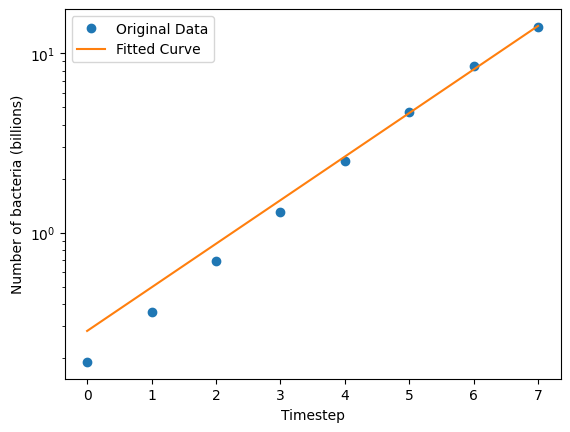

In [14]:
import matplotlib.pyplot as plt

initial_guess = np.array([data[0], 0.1])
x = np.arange(len(data))
y = data[:]

result_params = gauss_newton(initial_guess, x, y, growth)

p_0_fit, r_fit = result_params
fit_curve = growth((p_0_fit, r_fit), x)

print("Fitted parameters:")
print("p_0:", p_0_fit)
print("r:", r_fit)

plt.semilogy(np.arange(len(data)), data, 'o', label='Original Data')
plt.semilogy(np.arange(len(data)), fit_curve, label='Fitted Curve')
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Number of bacteria (billions)")
plt.show()

# (b)
Let $f$ be a vector valued function $f = [ f_1, \ldots, f_m ]^T$. In weighted least squares one aims to minimize the objective function
$$
  \phi(x) = \frac{1}{2} \sum_{i=1}^m W_{ii} ( y_i - f_i(x)) ^2 , \qquad
  W_{ii} = \frac{1}{\sigma_i^2} , 
$$
where $\sigma_i$ is an estimate of the standard deviation in the data point $y_i$. This is equivalent to the standard least squares problem 
$$
\min_x \frac{1}{2} \| Y - F(x) \|_2^2
$$
with $F_i(x) = \frac{1}{\sigma_i} f(x)$  , $Y_i = \frac{1}{\sigma_i} y_i$. Assume that for each data point $y_i$ in the list above, the estimate for the standard deviation is given by
$$
  \sigma_i = 0.05 y_i .
$$ 
Perform a weighted least squares fit to obtain estimates for $P_0$ and $r$. 

Plot the datapoints and the curve fitted to the data again in a semilogarithmic plot.

Compare the residuals, i.e. the values of $y_i - f_i(x)$) obtained in (a) and (b), and discuss the differences between the results of the weighted and the unweighted optimization.


Fitted parameters:
p_0: 0.1973659326691082
r: 1.8619753993837331


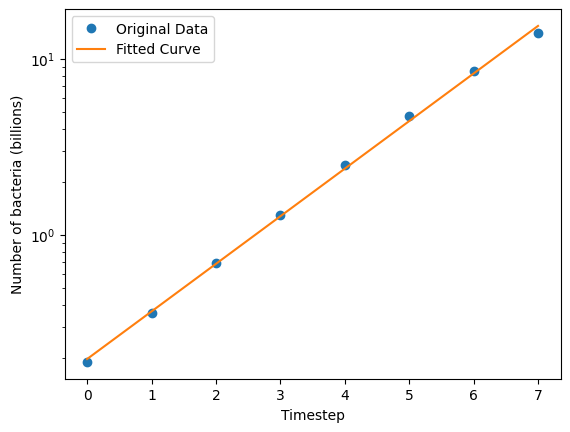

In [15]:
sigmas = 0.05 * y

initial_guess = np.array([data[0], 0.1])

result_params = gauss_newton(initial_guess, x, y, growth, sigmas=sigmas)

p_0_fit, r_fit = result_params
fit_curve_weighted = growth((p_0_fit, r_fit), x)

print("Fitted parameters:")
print("p_0:", p_0_fit)
print("r:", r_fit)

plt.semilogy(np.arange(len(data)), data, 'o', label='Original Data')
plt.semilogy(np.arange(len(data)), fit_curve_weighted, label='Fitted Curve')
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Number of bacteria (billions)")
plt.show()

## Comparison A B

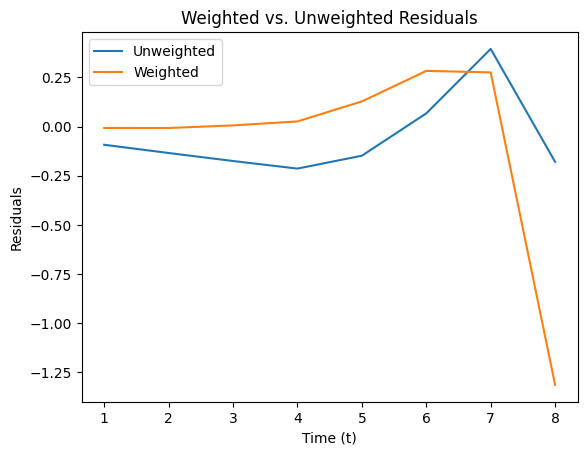

In [16]:
def compare_residuals(t, P):
    """
    Compare and visualize the residuals of two sets of data.

    Parameters:
    - t (array-like): Time values corresponding to the data points.
    - P (array-like): Observed data points to be compared.
    """

    # Compute residuals
    residuals = P - fit_curve
    residuals_weighted = P - fit_curve_weighted

    # Plotting
    plt.plot(t, residuals, label='Unweighted')
    plt.plot(t, residuals_weighted, label='Weighted')
    
    plt.title('Weighted vs. Unweighted Residuals')
    plt.xlabel('Time (t)')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()


P = np.array([0.19, 0.36, 0.69, 1.3, 2.5, 4.7, 8.5, 14])

# Comparing the residuals
compare_residuals(np.arange(1, 9), P)

The values of the weighted residuals are generally smaller, and the variation appears to be more gradual. This is the case until approx. t = 7, after which the unweighted residuals appear to be a better fit to the obeserved data. 

# Exercise 2 (3 points)
A triangle has been measured. The measurements, a vector $x \in \mathbb{R}^6$, are as follows:
$$\begin{array}{c|c|c|c|c|c}
x_1 = \alpha 
& x_2 = \beta
& x_3 = \gamma
& x_4 = a
& x_5 = b
& x_6 = c \\ \hline
67.5^{\large\circ}
& 52^{\large\circ}
& 60^{\large\circ}
& 172 \text{m}
& 146 \text{m}
& 165 \text{m}
\end{array} .
$$
Here $\alpha, \beta, \gamma$ are the angles opposite the sides with length $a$, $b$, $c$, respectively.
The measurements $x$ have errors. We would like to correct them so that the new values $\tilde{x} = x + h$ are consistent quantities of a triangle. The have to satisfy:
$$ \tag{*}
\begin{array}{ccc}
\text{Sum of angles:} 
& \;\;\;\;\; & 
\tilde{x}_1 + \tilde{x}_2 + \tilde{x}_3 = 180^{\large\circ}
\\
\text{Sine theorem:}
&&
\tilde{x}_4 \sin(\tilde{x}_2) - \tilde{x}_5 \sin(\tilde{x}_1) = 0
\\
&&
\tilde{x}_5 \sin(\tilde{x}_3) - \tilde{x}_6 \sin(\tilde{x}_2) = 0 .
\end{array}$$


## (a)
Solve the constrained least squares problem $\min_x \| h \|_2^2$ subject to the constraints given by (*).

Use `scipy.optimize.minimize`.

Hint: Don't forget to work in radians!

Check that for the new values also e.g. the cosine theorem $c^2 = a^2 + b^2 - 2 ab \cos(\gamma)$ holds.

In [17]:
from scipy.optimize import minimize

x_degrees_and_lengths = np.array([67.5, 52, 60, 172, 146, 165])
x_radians = np.radians(x_degrees_and_lengths[:3])

def residuals(h):
    """
    Compute the residuals based on corrected angles and lengths.

    Parameters:
    - h (numpy.ndarray): Optimization parameters representing corrections to angles and lengths.

    Returns:
    - numpy.ndarray: Residuals vector representing the deviation from the constraints.
    """
    tilde_x = np.concatenate([x_radians + h[:3], x_degrees_and_lengths[3:] + h[3:]])

    # constraints
    sum_of_angles_constraint = tilde_x[0] + tilde_x[1] + tilde_x[2] - np.pi
    sine_theorem1_constraint = tilde_x[3] * np.sin(tilde_x[1]) - tilde_x[4] * np.sin(tilde_x[0])
    sine_theorem2_constraint = tilde_x[4] * np.sin(tilde_x[2]) - tilde_x[5] * np.sin(tilde_x[1])

    return np.array([sum_of_angles_constraint, sine_theorem1_constraint, sine_theorem2_constraint])

# constrained least squares optimization
result = minimize(lambda h: np.linalg.norm(residuals(h))**2, x0=np.zeros(6), constraints={'type': 'eq', 'fun': residuals})

tilde_x_corrected = np.concatenate([x_radians + result.x[:3], x_degrees_and_lengths[3:] + result.x[3:]])

# check the cosine theorem
left_side = tilde_x_corrected[5]**2
right_side = tilde_x_corrected[3]**2 + tilde_x_corrected[4]**2 - 2 * tilde_x_corrected[3] * tilde_x_corrected[4] * np.cos(tilde_x_corrected[2])
cosine_theorem_check = abs(left_side - right_side)

print("Original angles (deg):\t", np.rad2deg(x_radians))
print("Corrected angles (deg):\t", np.rad2deg(tilde_x_corrected[:3]))
print("\n")
print("Original lengths:\t", x_degrees_and_lengths[-3:].tolist())
print("Corrected lengths:\t", tilde_x_corrected[-3:].tolist())
print("\n")
print("Cosine theorem check:", cosine_theorem_check)


Original angles (deg):	 [67.5 52.  60. ]
Corrected angles (deg):	 [66.83006818 51.29458836 61.87534346]


Original lengths:	 [172.0, 146.0, 165.0]
Corrected lengths:	 [172.00020435357638, 146.00011635665348, 164.99967602740895]


Cosine theorem check: 1.0986695997416973e-09


## (b)
You will notice that the corrections will be made mainly to the angles and much less to the lengths of the sides of the triangle. This is because the measurements have not the same absolute errors. While the error in last digit of the sides is about 1, the errors in radians of the angles are about 0.01. Repeat your computation by taking in account with appropriate weighting the difference in measurement errors. Minimize not simply $\| h \|_2^2$ but
$$
  \left\| \begin{bmatrix} 100 h_1 \\ 100 h_2 \\ 100 h_3 \\ h_4 \\ h_5 \\ h_6 \end{bmatrix} \right\|_2^2.$$

In [18]:
x_degrees_and_lengths = np.array([67.5, 52, 60, 172, 146, 165])
x_radians = np.radians(x_degrees_and_lengths[:3])

# added measurement errors/weights
errors = np.array([0.01, 0.01, 0.01, 1, 1, 1])

def residuals(h):
    """
    Compute the residuals based on corrected angles and lengths.

    Parameters:
    - h (numpy.ndarray): Optimization parameters representing corrections to angles and lengths.

    Returns:
    - numpy.ndarray: Residuals vector representing the deviation from the constraints.
    """
    tilde_x = np.concatenate([x_radians + h[:3], x_degrees_and_lengths[3:] + h[3:]])

    # Constraints
    sum_of_angles_constraint = tilde_x[0] + tilde_x[1] + tilde_x[2] - np.pi
    sine_theorem1_constraint = tilde_x[3] * np.sin(tilde_x[1]) - tilde_x[4] * np.sin(tilde_x[0])
    sine_theorem2_constraint = tilde_x[4] * np.sin(tilde_x[2]) - tilde_x[5] * np.sin(tilde_x[1])

    return np.array([sum_of_angles_constraint, sine_theorem1_constraint, sine_theorem2_constraint])

# weighted least squares optimization
result_weighted = minimize(lambda h: np.linalg.norm(residuals(h) / errors[:3])**2, x0=np.zeros(6), constraints={'type': 'eq', 'fun': residuals})

tilde_x_corrected_weighted = np.concatenate([x_radians + result_weighted.x[:3], x_degrees_and_lengths[3:] + result_weighted.x[3:]])

# check the cosine theorem
left_side_weighted = tilde_x_corrected_weighted[5]**2
right_side_weighted = tilde_x_corrected_weighted[3]**2 + tilde_x_corrected_weighted[4]**2 - 2 * tilde_x_corrected_weighted[3] * tilde_x_corrected_weighted[4] * np.cos(tilde_x_corrected_weighted[2])
cosine_theorem_check_weighted = abs(left_side_weighted - right_side_weighted)

print("Original Angles (degrees): \t\t\t", x_degrees_and_lengths[:3])
print("Corrected Angles (degrees) with weighting: \t", np.degrees(tilde_x_corrected_weighted[:3]))
print("\n")
print("Original Lengths: \t\t\t", x_degrees_and_lengths[3:])
print("Corrected Lengths with weighting: \t", tilde_x_corrected_weighted[3:])
print("\n")
print("Cosine Theorem Check with weighting:", cosine_theorem_check_weighted)


Original Angles (degrees): 			 [67.5 52.  60. ]
Corrected Angles (degrees) with weighting: 	 [66.86487559 51.23482667 61.90029773]


Original Lengths: 			 [172. 146. 165.]
Corrected Lengths with weighting: 	 [172.04467614 145.8778276  165.0378638 ]


Cosine Theorem Check with weighting: 1.7490201571490616e-06
